<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Plotting grid data with Landlab

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>


This tutorial illustrates how you can plot spatial data in Landlab, focusing in particular on Landlab's `imshow_grid` plotter and associated functions. Landlab's plotters are built onto the widely used Matplotlib Python package.

We start by importing the *NumPy* library, which we'll use in producing some data to plot:

In [1]:
import numpy as np

From Landlab, we'll need a grid on which to plot data, and a plotting function. We'll start with just `imshow_grid`, but be aware that similar but more specifically named functions like `imshow_grid_at_node` are also available. These all wrap the same basic Landlab functionality, so we're taking the most general method. 

In [2]:
from landlab import RasterModelGrid, RadialModelGrid, imshow_grid

We'll also need some functions from `matplotlib` proper to help us handle our graphical output:

In [4]:
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel

## Plotting in 2D

The `imshow_grid` plotter is Landlab's primary function for plotting data distributed across the grid. It's pretty powerful, and comes with a fairly extensive suite of options to control the appearance of your output. You can see the full list of options in the `imshow_grid` documentation.

However, most simply, it just takes `imshow_grid(grid, data)`. Data can be either a field name string, or an array of the data itself.

/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


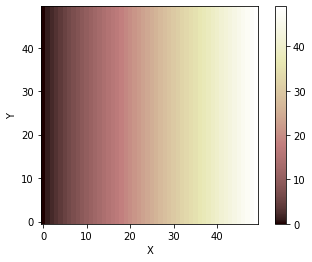

In [5]:
%matplotlib inline
rmg = RasterModelGrid((50, 50), 1.)
imshow_grid(rmg, rmg.x_of_node)  # plot the x distances at nodes
show()

Those units for the axis are taken from the grid property `axis_units`, which is a tuple that we can set. Alternatively, pass a tuple directly to the plotter with the keyword `grid_units`.

While we're at it, let's plot from a field instead of an array, and also mix up the default color scheme. The `cmap` keyword can take any input that you could also supply to matplotlib; see, e.g., http://matplotlib.org/examples/color/colormaps_reference.html.

/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_bad(color=color_for_closed)


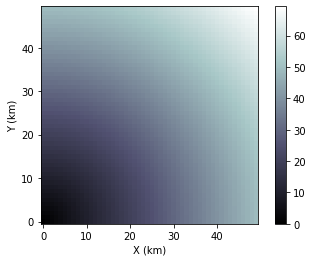

In [6]:
rmg.axis_units = ('km', 'km')
_ = rmg.add_field('myfield', (rmg.x_of_node**2 + rmg.y_of_node**2)**0.5,
                  at='node', clobber=True)
imshow_grid(rmg, 'myfield', cmap='bone')
show()

The plotter works just fine with both raster grids and irregular grids. Name a plot with the `var_name` keyword.

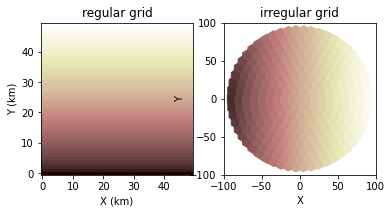

In [7]:
radmg = RadialModelGrid(n_rings=10, spacing=10.)
subplot(121)
imshow_grid(rmg, rmg.y_of_node, allow_colorbar=False, plot_name='regular grid')
subplot(122)
imshow_grid(radmg,
            radmg.x_of_node,
            allow_colorbar=False,
            plot_name='irregular grid')
show()

Now, let's look at some of the other more advanced options `imshow_grid` can provide.

`ishow_grid` offers plenty of keyword options for modifying the colorbar, including `var_name`, `var_units`, `symmetric_cbar`, `vmin`, `vmax`, and `shrink`. We've already seen `allow_colorbar`, which lets you suppress the bar entirely. Let's see some in action.

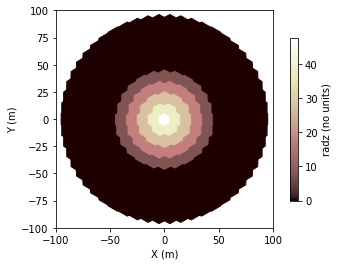

In [8]:
radz = (radmg.x_of_node**2 + radmg.y_of_node**2)**0.5
radz = radz.max() - radz - 0.75 * radz.mean()
# let's plot these elevations truncated at radz >= 0
imshow_grid(radmg,
            radz,
            grid_units=('m', 'm'),
            vmin=0.,
            shrink=0.75,
            var_name='radz',
            var_units='no units')
show()

Now let's explore color control. The grid takes the keyword `color_for_background`, which as you'd expect, colors any exposed part of the frame without cells over it. It knows the same color representations as matplotlib, e.g., (0., 0., 0.5), '0.3', 'b', 'yellow'.

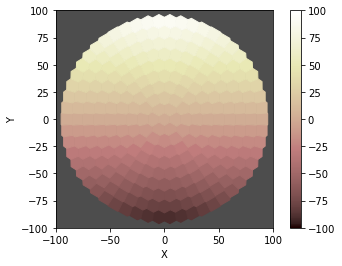

In [9]:
imshow_grid(radmg, radmg.y_of_node, color_for_background='0.3')
show()

The plotter knows about boundary condition status, and we can control the colour of such nodes as well. This is useful if plotting an irregular watershed on a raster, for example. Here, `None` means transparent, as we will see in the next example.

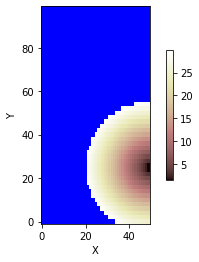

In [10]:
rmg2 = RasterModelGrid((50, 50), (1., 2.))
myvals = ((rmg2.x_of_node - 50.)**2 + (rmg2.y_of_node - 25.)**2)**0.5
rmg2.status_at_node[myvals > 30.] = rmg2.BC_NODE_IS_CLOSED
imshow_grid(rmg2, myvals, color_for_closed='blue', shrink=0.6)

Finally, note that the plotter recognises any masked node in a masked array as a closed node. This can be used as a convenient way to make grid overlays, as follows:

/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:269: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("winter").copy()
  cmap.set_bad(alpha=0.0)


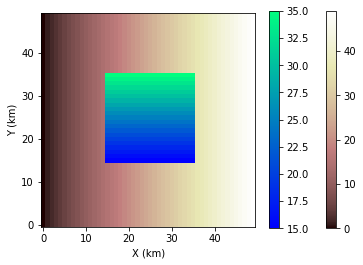

In [11]:
mymask_1stcondition = np.logical_or(rmg.x_of_node < 15, rmg.x_of_node > 35)
mymask_2ndcondition = np.logical_or(rmg.y_of_node < 15, rmg.y_of_node > 35)
mymask = np.logical_or(mymask_1stcondition, mymask_2ndcondition)
overlay_data = np.ma.array(rmg.y_of_node, mask=mymask, copy=False)
imshow_grid(rmg, rmg.x_of_node)
imshow_grid(rmg, overlay_data, color_for_closed=None, cmap='winter')
show()

## Plotting in 1D

Landlab basically lets you get on with it for yourself if plotting cross sections, or otherwise in 1D. We recommend the basic matplotlib plotting suite. Often `plot()` is totally adequate.

For a simple grid cross section, just reshape the data array back to a raster and take a slice:

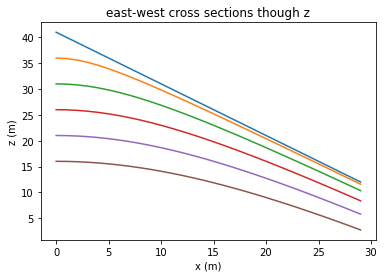

In [12]:
# Note, in Landlab 2.0 a new component that will permit profiles based on endpoints
# will be added to the component library.

mg = RasterModelGrid((30, 30))
z = (mg.x_of_node**2 + mg.y_of_node**2)**0.5
z = z.max() - z
z_raster = z.reshape(mg.shape)
x_raster = mg.x_of_node.reshape(mg.shape)
for i in range(0, 30, 5):
    plot(x_raster[i, :], z_raster[i, :])
title('east-west cross sections though z')
xlabel('x (m)')
ylabel('z (m)')
show()

Additionally, Landlab makes available a stream profiler tool. It finds the highest drainage area node in a landscape whenever it's called, then follows the drainage structure back upstream from that node, always choosing the upstream node with the highest drainage area. This means we can do things like this:

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


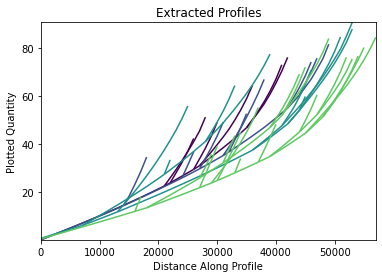

/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/Users/joshwolpert/opt/anaconda3/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


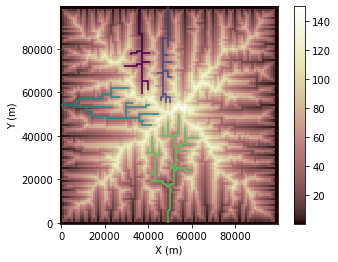

In [13]:
from landlab.components import FlowAccumulator, FastscapeEroder, ChannelProfiler

mg = RasterModelGrid((100, 100), 1000.)
mg.axis_units = ('m', 'm')
z = mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(mg.number_of_nodes)  # roughen the initial surface

fr = FlowAccumulator(mg)
sp = FastscapeEroder(mg, K_sp=1.e-5)
dt = 50000.

for ndt in range(100):
    z[mg.core_nodes] += 10.
    fr.run_one_step()
    sp.run_one_step(dt)
    if ndt % 5 == 0:
        print(ndt)

prf = ChannelProfiler(mg,
                      number_of_watersheds=4,
                      main_channel_only=False,
                      minimum_channel_threshold=1e7)
prf.run_one_step()

figure(1)
prf.plot_profiles()
show()

figure(1)
prf.plot_profiles_in_map_view()
show()

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>